In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

In [2]:
mutable struct HGF <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function HGF(X, ξ; id=ForneyLab.generateId(HGF))
        
        # ensure that the input arguments are random variables
        @ensureVariables(X, ξ) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 2), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:X] = self.interfaces[1] = ForneyLab.associate!(Interface(self), X)
        self.i[:ξ] = self.interfaces[2] = ForneyLab.associate!(Interface(self), ξ)
        
        # return object
        return self
    end
end

In [3]:
function ruleVariationalHGFOutNP(marg_X::Nothing, 
                                 marg_ξ::ProbabilityDistribution{ForneyLab.Multivariate})
    
    # caluclate required mean
    mξ = ForneyLab.unsafeMean(marg_ξ)

    # calculate required variance
    vξ = diag(ForneyLab.unsafeCov(marg_ξ))

    # calculate new parameters
    mX = zeros(size(mξ))
    vX = exp.(mξ - vξ/2)
    
    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=mX./vX, w=diagm(1 ./ vX))

end

ruleVariationalHGFOutNP (generic function with 1 method)

In [4]:
function ruleVariationalHGFIn1PN(marg_X::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                 marg_ξ::Nothing)
    
    # calculate required means
    mX = ForneyLab.unsafeMean(marg_X)

    # calculate required variances
    vX = diag(ForneyLab.unsafeCov(marg_X))

    # calculate new parameters
    mξ = log.(mX.^2 + vX)
    vξ = 2.0*ones(length(mξ))

    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=mξ./vξ, w=diagm(1 ./ vξ))

end

ruleVariationalHGFIn1PN (generic function with 1 method)

In [5]:
@naiveVariationalRule(:node_type     => HGF,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (Nothing, ProbabilityDistribution),
                      :name          => VariationalHGFOutNP)

@naiveVariationalRule(:node_type     => HGF,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing),
                      :name          => VariationalHGFIn1PN)

In [6]:
# number of frequency bins (cosine coefs only for now) TO DISCUSS
nr_freqs = 5

# create factor graph
fg = FactorGraph()

# gaussian mixture 
@RV [id=:ξ] ξ ~ GaussianMeanVariance(placeholder(:μ_ξ, dims=(nr_freqs,)), placeholder(:Σ_ξ, dims=(nr_freqs,nr_freqs)))

# HGF
@RV [id=:X] X ~ HGF(ξ)

# observation model
@RV [id=:y] y ~ GaussianMeanVariance(X, placeholder(:Σ_y, dims=(nr_freqs,nr_freqs)))
placeholder(y, :y, dims=(nr_freqs,))

# draw graph
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4949626389537091872 -->
 4949626389537091872 
 
 HGF 
 hgf_1 
 
<!-- 2616378668315190119 -->
 2616378668315190119 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 4949626389537091872--2616378668315190119 -->
 4949626389537091872--2616378668315190119 
 
 ξ 
 1 out 
 2 ξ 
 
<!-- 5924570267652917797 -->
 5924570267652917797 
 
 placeholder_Σ_ξ 
 
<!-- 1900651501011541213 -->
 1900651501011541213 
 
 placeholder_μ_ξ 
 
<!-- 10637083471587858473 -->
 10637083471587858473 
 
 placeholder_Σ_y 
 
<!-- 3383959931722605866 -->
 3383959931722605866 
 
 placeholder_y 
 
<!-- 11154323782461207326 -->
 11154323782461207326 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 3383959931722605866--11154323782461207326 -->
 3383959931722605866--11154323782461207326 
 
 y 
 1 out 
 1 out 
 
<!-- 11154323782461207326--4949626389537091872 -->
 11154323782461207326--4949626389537091872 
 
 X 
 1 X 
 2 m 
 
<!-- 11154323782461207326--10637083471587858473 -->
 11154323782461207326--10637083471587858473 
 
 Σ_y 
 1 out 
 3 v 
 
<!-- 2616378668315190119--5924570267652917797 -->
 2616378668315190119--5924570267652917797 
 
 Σ_ξ 
 1 out 
 3 v 
 
<!-- 2616378668315190119--1900651501011541213 -->
 2616378668315190119--1900651501011541213 
 
 μ_ξ 
 1 out 
 2 m

In [7]:
# generate data
N = 5000

μ_ξ = 1.0*collect(1:nr_freqs)
Σ_ξ = 1e0*diagm(collect(2:2:2*nr_freqs))
Σ_meas = 1e-10*Ic(nr_freqs)

ξ_samples = Array{Float64,2}(undef, N, nr_freqs)
X_samples = Array{Float64,2}(undef, N, nr_freqs)
y_samples = Array{Float64,2}(undef, N, nr_freqs)

for n = 1:N

    sample_ξ = rand(MvNormal(μ_ξ, Σ_ξ))
    sample_X = rand(MvNormal(zeros(nr_freqs), exp.(sample_ξ)))
    sample_y = rand(MvNormal(sample_X, Σ_meas))
    
    ξ_samples[n,:] = sample_ξ
    X_samples[n,:] = sample_X
    y_samples[n,:] = sample_y
    
end

t = collect(1:N)
;

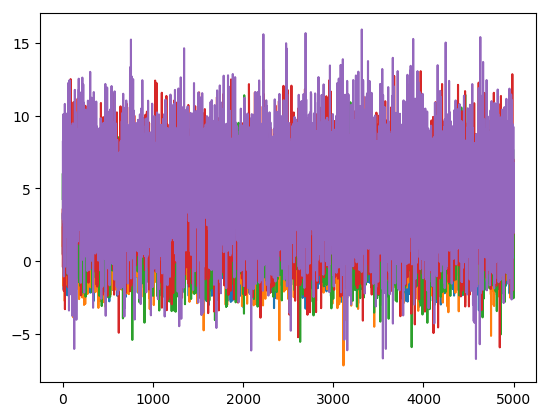

In [8]:
plt.plot(t, ξ_samples);

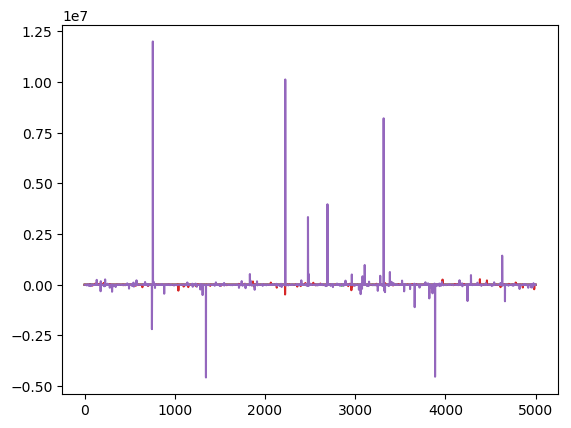

In [9]:
plt.plot(t, X_samples);

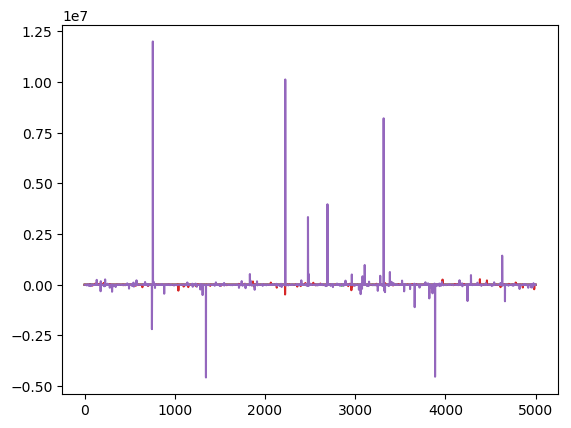

In [10]:
plt.plot(t,y_samples);

In [11]:
q = PosteriorFactorization(X, ξ, ids=[:X :ξ])
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepξ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_ξ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_ξ]))
messages[2] = ruleVariationalHGFIn1PN(marginals[:X], nothing)

marginals[:ξ] = messages[1].dist * messages[2].dist

return marginals

end

function stepX!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVariationalHGFOutNP(nothing, marginals[:ξ])
messages[2] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_y]))

marginals[:X] = messages[1].dist * messages[2].dist

return marginals

end

end # block


In [12]:
μ_ξ_mem = Array{Float64,2}(undef, N, nr_freqs)
Σ_ξ_mem = Array{Float64,2}(undef, N, nr_freqs)

# priors
μ_ξ = zeros(nr_freqs)
Σ_ξ = 10*Ic(nr_freqs)
Σ_y = 1e-10*Ic(nr_freqs)

marginals = Dict()

for n = 1:N
        
    # fill marginals dictionary
    marginals[:ξ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_ξ, v=Σ_ξ)
    
    # fill data dictionary
    data = Dict()
    data[:μ_ξ] = μ_ξ
    data[:Σ_ξ] = Σ_ξ
    data[:Σ_y] = Σ_y
    data[:y] = y_samples[n,:]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(stepX!, data, marginals)
        Base.invokelatest(stepξ!, data, marginals)
    end
    
    # update parameters
    μ_ξ = ForneyLab.unsafeMean(marginals[:ξ])
    Σ_ξ = ForneyLab.unsafeCov(marginals[:ξ])

    # save parameters
    μ_ξ_mem[n,:] = μ_ξ
    Σ_ξ_mem[n,:] = diag(Σ_ξ)
    
end

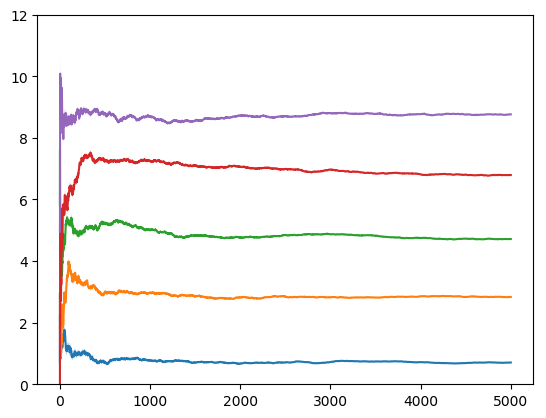

(0, 12)

In [13]:
for k = 1:nr_freqs
    plt.plot(t, μ_ξ_mem[:,k])
    plt.fill_between(t, μ_ξ_mem[:,k] - sqrt.(Σ_ξ_mem[:,k]), μ_ξ_mem[:,k] + sqrt.(Σ_ξ_mem[:,k]), alpha=0.3)
end
plt.ylim(0,12)